In [1]:
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing import image, image_dataset_from_directory
from keras.models import Sequential, Model
from keras.layers import Dense, AveragePooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
import pandas as pd
import os
import shutil
from tqdm import tqdm

In [2]:
from tensorflow import ones_like
from tensorflow.math import equal, log, multiply
from keras import backend as K
import tensorflow as tf



def weighted_binary_crossentropy(w1, w2):
  

    def loss(y_true, y_pred):
        # avoid absolute 0
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        ones = ones_like(y_true)
        msk = equal(y_true, ones)
        # tensor of booleans of length == y_true; true means that the true class is 1

        res, _ = tf.map_fn(lambda x: (multiply(-log(x[0]), w1) if x[1] is True
                                      else multiply(-log(1 - x[0]), w2), x[1]),
                           (y_pred, msk), dtype=(tf.float32, tf.bool))

        return res

    return loss
  

    

    

In [3]:
train=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/train.csv')
train = train.fillna(0)
# import valid data info from valid.csv
valid=pd.read_csv('/home/jupyter-zaiman/data/DataCenter/CheXpert-v1.0/valid.csv')
valid = valid.fillna(0)

valid = valid.append(valid)

#pre-process data: remove Lateral images
train = train[~train[train.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
train = train.filter(["Path", "No Finding"], axis=1)
train['No Finding'] = train['No Finding'].astype(str)
print(train.shape)
train.head(20)

(191027, 2)


,Path,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,0.0
5,CheXpert-v1.0/train/patient00004/study1/view1_...,1.0
7,CheXpert-v1.0/train/patient00005/study1/view1_...,1.0
9,CheXpert-v1.0/train/patient00005/study2/view1_...,0.0
10,CheXpert-v1.0/train/patient00005/study2/view2_...,0.0
11,CheXpert-v1.0/train/patient00006/study1/view1_...,1.0
12,CheXpert-v1.0/train/patient00007/study1/view1_...,0.0


In [4]:
train = train.sample(frac=1)
valid_size = round(0.1*int((train.shape[0]/3)))
test_size = valid_size
dftr = train[0:int((train.shape[0]/3))-valid_size-test_size+1]
dfv = train[int((train.shape[0]/3))-valid_size-test_size:int((train.shape[0]/3))-valid_size+1]
dfte = train[int((train.shape[0]/3))-valid_size:int((train.shape[0]/3))+1]

In [5]:
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
EPOCHS = 50
BATCH_SIZE = 1024
TEST_SIZE = 64
learning = 0.00001
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2
    )
valid_datagen = ImageDataGenerator(
        rescale=1./255
    )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=dftr, 
    directory='/home/jupyter-zaiman/data/DataCenter/',
    x_col="Path", y_col="No Finding", 
    class_mode="binary", 
    target_size=(224, 224), 
    batch_size=BATCH_SIZE)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dfv, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(224, 224), batch_size=TEST_SIZE)
test_generator=valid_datagen.flow_from_dataframe(dataframe=dfte, directory='/home/jupyter-zaiman/data/DataCenter/', x_col="Path", y_col="No Finding", class_mode="binary", target_size=(224, 224), shuffle = False, batch_size=1)

Found 50940 validated image filenames belonging to 2 classes.
Found 6369 validated image filenames belonging to 2 classes.
Found 6369 validated image filenames belonging to 2 classes.


In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
def create_model():
   
    base = ResNet50(weights='imagenet', include_top=False, pooling='max')
    for layer in base.layers:
        layer.trainable = False
    for layer in [l for l in base.layers if 'conv5' in l.name or l.name == 'probs']:
           layer.trainable = True

    x = Flatten()(base.output)
    x = Dense(1024, activation = 'relu')(x)
    prediction = Dense(2, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=prediction)
    

    
    model.summary()
    return model

In [8]:
def train_base(model, train_ds, valid_ds):     
    class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_ds.classes), 
                train_ds.classes
    )
    class_weights = {i : class_weights[i] for i in range(2)}
    model.compile(optimizer=Adam(lr=learning), loss=weighted_binary_crossentropy(class_weights[0], class_weights[1]), 
                  metrics=['accuracy'])
    
    
    save = ModelCheckpoint(
        '/home/jupyter-zaiman/ResNet50_Data/saves', 
        monitor='val_loss', 
        save_best_only=True,
        save_weights_only=True, 
        mode='min',
        verbose=1
    )
    stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=8)
    lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.01,
        patience=4,
        verbose=1
    )
    logger = CSVLogger('/home/jupyter-zaiman/ResNet50_Data/saves/training_data.log')
    history = model.fit(train_ds, 
        epochs=EPOCHS, 
#         steps_per_epoch=len(train_ds.filenames) // BATCH_SIZE, 
        validation_data=valid_ds, 
#         validation_steps=len(valid_ds.filenames) // BATCH_SIZE, 
        verbose=1, 
        class_weight = class_weights,
        callbacks=[lr, stop, save, logger]
    )
    model.save=('resnet.h5')
    return history
    



In [9]:
def getMetrics(model, history):
    print(history.history.keys())
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    
    Y_pred = model.predict(test_generator, len(test_generator.filenames))
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    target_names = ['Abnormal', 'Normal']
    print('Classification Report')
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [10]:
res = create_model()
hist = train_base(res, train_generator, valid_generator)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

/home/jupyter-zaiman/.conda/envs/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead
50/50 [==============================] - ETA: 0s - loss: 6.8857 - accuracy: 0.4969  
Epoch 00001: val_loss improved from inf to 7.90276, saving model to /home/jupyter-zaiman/ResNet50_Data/saves
50/50 [==============================] - 4271s 85s/step - loss: 6.8857 - accuracy: 0.4969 - val_loss: 7.9028 - val_accuracy: 0.9155
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 4.4410 - accuracy: 0.4999  
Epoch 00002: val_loss did not improve from 7.90276
50/50 [==============================] - 3992s 80s/step - loss: 4.4410 - accuracy: 0.4999 - val_loss: 8.4677 - val_accuracy: 0.9155
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 4.3069 - accuracy: 0.5034  
Epoch 00003: val_loss did not improve from 7.90276
50/50 [==============================] - 3970s 79s/step - loss: 4.3069 - accuracy: 0.5034 - val_loss: 8.9606 - val_accuracy: 0.9155
Epoch 4/50
50/50 [============================

Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 3.9467 - accuracy: 0.4986  
Epoch 00026: val_loss did not improve from 3.97087
50/50 [==============================] - 4841s 97s/step - loss: 3.9467 - accuracy: 0.4986 - val_loss: 3.9927 - val_accuracy: 0.6989
Epoch 27/50
50/50 [==============================] - ETA: 0s - loss: 3.9711 - accuracy: 0.5041  
Epoch 00027: val_loss did not improve from 3.97087
50/50 [==============================] - 4868s 97s/step - loss: 3.9711 - accuracy: 0.5041 - val_loss: 4.0328 - val_accuracy: 0.7852
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 3.9892 - accuracy: 0.5021  
Epoch 00028: val_loss did not improve from 3.97087
50/50 [==============================] - 4843s 97s/step - loss: 3.9892 - accuracy: 0.5021 - val_loss: 4.0311 - val_accuracy: 0.7874
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 3.9742 - accuracy: 0.5065  
Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.9999

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


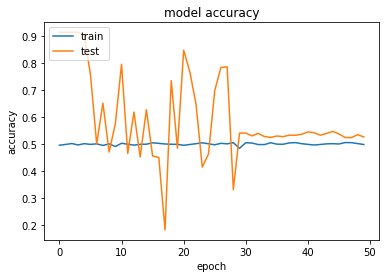

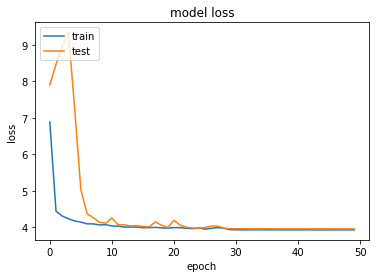

Confusion Matrix
[[3124 2676]
 [ 303  266]]
Classification Report
              precision    recall  f1-score   support

    Abnormal       0.91      0.54      0.68      5800
      Normal       0.09      0.47      0.15       569

    accuracy                           0.53      6369
   macro avg       0.50      0.50      0.41      6369
weighted avg       0.84      0.53      0.63      6369



In [12]:
getMetrics(res, hist)